# Image Classification with CNN

## 1. Introduction

### 1.1 Load packages

In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras

In [2]:
# miscellaneous
import warnings
warnings.filterwarnings("ignore")

### 1.2 Getting images data into keras

In [3]:
# this are the folder names
classes = os.listdir('./train_images')
classes

['book', 'mug', 'fork', 'phone']

In [4]:
# define an image data generator
data_gen = keras.preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=keras.applications.mobilenet_v2.preprocess_input,
    
# rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True, 
    # zoom_range=0.2,
   
)

In [5]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory='./train_images',
        class_mode="categorical",
        classes=classes,
        batch_size=480,
        target_size=(224, 224)
)

Found 480 images belonging to 4 classes.


In [6]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((480, 224, 224, 3), (480, 4))

## 2. Model Building 

### 2.1 Select the convolutional base and freeze the weights

In [7]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=1.0,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

# freeze it!
base_model.trainable = False

In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

### 2.2 Add dense layers on top

In [9]:
def model_builder(hp):
    '''
    Args:
    hp - Keras tuner object
    '''
    # Initialize the Sequential API and start stacking the layers
    model = keras.Sequential()
    model.add(base_model)
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-160
    hp_units = hp.Int('units', min_value=32, max_value=160, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Add next layers
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(len(classes), activation='softmax'))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

    return model

## 3. Hyperparameter Tuning

In [10]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_categorical_accuracy', # objective to optimize
                     max_epochs=50,
                     hyperband_iterations=3,
                     project_name='tuning_results')

In [11]:
# hypertuning settings
tuner.search_space_summary() 

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 160, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [12]:
# Perform hypertuning
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tf.autograph.experimental.do_not_convert
tuner.search(xtrain, ytrain,
             epochs=50,
             batch_size=16,
             callbacks=[stop_early],
             validation_split=1/6)

Trial 15 Complete [00h 00m 13s]
val_categorical_accuracy: 0.9750000238418579

Best val_categorical_accuracy So Far: 1.0
Total elapsed time: 00h 03m 15s
INFO:tensorflow:Oracle triggered exit


In [13]:
# best_model = tuner.get_best_models(1)[0]

In [14]:
# best hyperparameters
best_hp=tuner.get_best_hyperparameters(1)[0]

In [15]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 2,422,468
Trainable params: 164,484
Non-trainable params: 2,257,984
_________________________________________________________________


## 4. Model Training

In [16]:
tf.autograph.experimental.do_not_convert
h_model.fit(xtrain, ytrain,
            epochs=50,
            batch_size=16,
            callbacks=[stop_early],
            validation_split=1/6)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/25 [==============================] - ETA: 0s - loss: 0.6695 - categorical_accuracy: 0.7675WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f58a8a5ec20> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSI

In [17]:
losses = pd.DataFrame(h_model.history.history) # losses in the training history
epoch = losses.index.values+np.ones_like(losses.index.values) # epoch number
loss = losses['loss'].values # training loss
val_loss = losses['val_loss'].values # validation loss

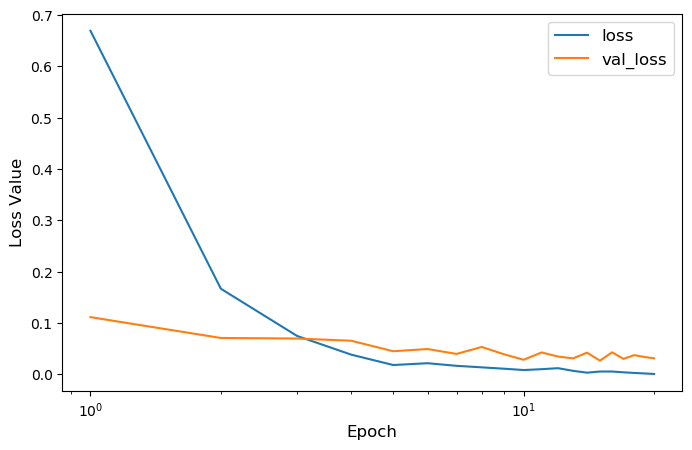

In [18]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,5),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss Value',fontsize=12)
plt.legend(loc=1,fontsize=12)
None

## 5. Model Evaluation

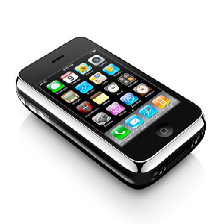

In [19]:
img_test = keras.preprocessing.image.load_img('test_images/phone_1.png', target_size=(224,224))
img_test

In [20]:
def image_classification(image_path, model):
    image = keras.preprocessing.image.load_img(image_path, target_size=(224,224))
    pic_array = keras.preprocessing.image.img_to_array(image)
    image_batch = np.expand_dims(pic_array, axis=0)
    processed_image = keras.applications.mobilenet_v2.preprocess_input(image_batch)
    probs = h_model.predict(processed_image)[0].tolist()
    zipped = sorted(list(zip(classes, probs)), key=lambda x: x[1], reverse=True)
    image_class = [zipped[i][0] for i in range(len(zipped))]
    probability  = [zipped[i][1]*100 for i in range(len(zipped))]
    df = pd.DataFrame(data={'image_class':image_class, 'probability(%)': probability})
    return df

In [23]:
tf.autograph.experimental.do_not_convert
image_classification('test_images/phone_1.png', h_model)

,image_class,probability(%)
0,phone,99.937505
1,book,0.033427
2,mug,0.023842
3,fork,0.005226
